In [1]:
%matplotlib inline
# coding=utf-8
import os, sys, gc, ipaddress, time, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as ply
from functools import reduce
from scipy import linalg
from sklearn import preprocessing
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import pairwise_distances
warnings.filterwarnings("ignore")

In [2]:
def data_cleasing(m_df):
    # data cleasing, feature engineering and save clean data into pickles

    print('### Data Cleasing and Feature Engineering')
    le = preprocessing.LabelEncoder()

    # [Protocol] - Discard ipv6-icmp and categorize
    m_df = m_df[m_df.Proto != 'ipv6-icmp']
    m_df['Proto'] = m_df['Proto'].fillna('-')
    m_df['Proto'] = le.fit_transform(m_df['Proto'])

    # [Label] - Categorize
    anomalies = m_df.Label.str.contains('Botnet')
    normal = np.invert(anomalies)
    m_df.loc[anomalies, 'Label'] = np.uint8(1)
    m_df.loc[normal, 'Label'] = np.uint8(0)
    m_df['Label'] = pd.to_numeric(m_df['Label'])

    # [Dport] - replace NaN with 0 port number
    m_df['Dport'] = m_df['Dport'].fillna('0')
    m_df['Dport'] = m_df['Dport'].apply(lambda x: int(x, 0))

    # [sport] - replace NaN with 0 port number
    try:
        m_df['Sport'] = m_df['Sport'].fillna('0')
        m_df['Sport'] = m_df['Sport'].str.replace('.*x+.*', '0')
        m_df['Sport'] = m_df['Sport'].apply(lambda x: int(x, 0))
    except:
        print("Unexpected error:", sys.exc_info()[0])

    # [sTos] - replace NaN with "10" and convert to int
    m_df['sTos'] = m_df['sTos'].fillna('10')
    m_df['sTos'] = m_df['sTos'].astype(int)

    # [dTos] - replace NaN with "10" and convert to int
    m_df['dTos'] = m_df['dTos'].fillna('10')
    m_df['dTos'] = m_df['dTos'].astype(int)

    # [State] - replace NaN with "-" and categorize
    m_df['State'] = m_df['State'].fillna('-')
    m_df['State'] = le.fit_transform(m_df['State'])

    # [Dir] - replace NaN with "-" and categorize
    m_df['Dir'] = m_df['Dir'].fillna('-')
    m_df['Dir'] = le.fit_transform(m_df['Dir'])

    # [SrcAddr] Extract subnet features and categorize
    m_df['SrcAddr'] = m_df['SrcAddr'].fillna('0.0.0.0')

    # [DstAddr] Extract subnet features
    m_df['DstAddr'] = m_df['DstAddr'].fillna('0.0.0.0')

    # [StartTime] - Parse to datatime, reindex based on StartTime, but first drop the ns off the time stamps
    m_df['StartTime'] = m_df['StartTime'].apply(lambda x: x[:19])
    m_df['StartTime'] = pd.to_datetime(m_df['StartTime'])

    m_df = m_df.set_index('StartTime')

    gc.collect()

    return m_df


def classify_ip(ip):
    """
    str ip - ip address string to attempt to classify. treat ipv6 addresses as N/A
    """
    try:
        ip_addr = ipaddress.ip_address(ip)
        if isinstance(ip_addr, ipaddress.IPv6Address):
            return 'ipv6'
        elif isinstance(ip_addr, ipaddress.IPv4Address):
            # split on .
            octs = ip_addr.exploded.split('.')
            if 0 < int(octs[0]) < 127:
                return 'A'
            elif 127 < int(octs[0]) < 192:
                return 'B'
            elif 191 < int(octs[0]) < 224:
                return 'C'
            else:
                return 'N/A'
    except ValueError:
        return 'N/A'


def avg_duration(x):
    return np.average(x)


def n_dports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a, b: a + b if b > 1024 else a), x)


n_dports_gt1024.__name__ = 'n_dports>1024'


def n_dports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a, b: a + b if b < 1024 else a), x)


n_dports_lt1024.__name__ = 'n_dports<1024'


def n_sports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a, b: a + b if b > 1024 else a), x)


n_sports_gt1024.__name__ = 'n_sports>1024'


def n_sports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a, b: a + b if b < 1024 else a), x)


n_sports_lt1024.__name__ = 'n_sports<1024'


def label_atk_v_norm(x):
    for l in x:
        if l == 1: return 1
    return 0


label_atk_v_norm.__name__ = 'label'


def background_flow_count(x):
    count = 0
    for l in x:
        if l == 0: count += 1
    return count


def normal_flow_count(x):
    if x.size == 0: return 0
    count = 0
    for l in x:
        if l == 0: count += 1
    return count


def n_conn(x):
    return x.size


def n_tcp(x):
    count = 0
    for p in x:
        if p == 10: count += 1  # tcp == 10
    return count


def n_udp(x):
    count = 0
    for p in x:
        if p == 11: count += 1  # udp == 11
    return count


def n_icmp(x):
    count = 0
    for p in x:
        if p == 1: count += 1  # icmp == 1
    return count


def n_s_a_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'A': count += 1
    return count


def n_d_a_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'A': count += 1
    return count


def n_s_b_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'B': count += 1
    return count


def n_d_b_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'A': count += 1
    return count


def n_s_c_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'C': count += 1
    return count


def n_d_c_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'C': count += 1
    return count


def n_s_na_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'N/A': count += 1
    return count


def n_d_na_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'N/A': count += 1
    return count


def n_ipv6(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'ipv6': count += 1
    return count


def print_classification_report(y_test, y_predic):
    m_f1 = f1_score(y_test, y_predic, average="binary")
    m_recall = recall_score(y_test, y_predic, average="binary")
    m_precision = precision_score(y_test, y_predic, average="binary")
    print('\tF1 Score: ', m_f1, ', Recall: ', m_recall, ', Precision: ,', m_precision)


def get_classification_report(y_test, y_predic):
    m_f1 = f1_score(y_test, y_predic, average = "binary")
    m_recall = recall_score(y_test, y_predic, average = "binary")
    m_precision = precision_score(y_test, y_predic, average = "binary")
    return m_f1, m_recall, m_precision


def data_splitting(m_df, drop_feature):
    # drop non discriminant features
    m_df.drop(drop_feature, axis=1, inplace=True)

    # split into normal and anomaly
    df_l1 = m_df[m_df["Label"] == 1]
    df_l0 = m_df[m_df["Label"] == 0]
    gc.collect()

    # Length and indexes
    anom_len = len(df_l1)  # total number of anomalous flows
    anom_train_end = anom_len // 2  # 50% of anomalous for training
    anom_cv_start = anom_train_end + 1  # 50% of anomalous for testing
    norm_len = len(df_l0)  # total number of normal flows
    norm_train_end = (norm_len * 60) // 100  # 60% of normal for training
    norm_cv_start = norm_train_end + 1  # 20% of normal for cross validation
    norm_cv_end = (norm_len * 80) // 100  # 20% of normal for cross validation
    norm_test_start = norm_cv_end + 1  # 20% of normal for testing

    # anomalies split data
    anom_cv_df = df_l1[:anom_train_end]  # 50% of anomalies59452
    anom_test_df = df_l1[anom_cv_start:anom_len]  # 50% of anomalies
    gc.collect()

    # normal split data
    m_norm_train_df = df_l0[:norm_train_end]  # 60% of normal
    norm_cv_df = df_l0[norm_cv_start:norm_cv_end]  # 20% of normal
    norm_test_df = df_l0[norm_test_start:norm_len]  # 20% of normal
    gc.collect()

    # CV and test data. train data is norm_train_df
    m_cv_df = pd.concat([norm_cv_df, anom_cv_df], axis=0)
    m_test_df = pd.concat([norm_test_df, anom_test_df], axis=0)
    gc.collect()

    # Sort data by index
    m_norm_train_df = m_norm_train_df.sort_index()
    m_cv_df = m_cv_df.sort_index()
    m_test_df = m_test_df.sort_index()
    gc.collect()

    # save labels and drop labels from data
    m_cv_label = m_cv_df["Label"]
    m_test_label = m_test_df["Label"]
    m_norm_train_df = m_norm_train_df.drop(labels=["Label"], axis=1)
    m_cv_df = m_cv_df.drop(labels=["Label"], axis=1)
    m_test_df = m_test_df.drop(labels=["Label"], axis=1)

    gc.collect()

    return m_norm_train_df, m_cv_df, m_test_df, m_cv_label, m_test_label


def getBestByNormalCV(t_normal, cv, t_cv_label):

    # prepare data
    m_cv_label = t_cv_label.astype(np.int8)
    m_cv_label[m_cv_label == 1] = -1
    m_cv_label[m_cv_label == 0] = 1

    # initialize
    m_best_model = EllipticEnvelope()
    m_best_contamination = 0
    m_best_f1 = 0
    m_best_precision = 0
    m_best_recall = 0

    m_contamination = 0.01
    # configure GridSearchCV
    m_ell_model = EllipticEnvelope(contamination = m_contamination)
    m_ell_model.fit(t_normal)
    m_pred = m_ell_model.predict(cv)

    m_f1 = f1_score(m_cv_label, m_pred, average="binary")
    m_recall = recall_score(m_cv_label, m_pred, average="binary")
    m_precision = precision_score(m_cv_label, m_pred, average="binary")

    if m_f1 > m_best_f1:
        m_best_model = m_ell_model
        m_best_contamination = m_contamination
        m_best_f1 = m_f1
        m_best_precision = m_precision
        m_best_recall = m_recall

    return m_best_model, m_best_contamination, m_best_f1, m_best_precision, m_best_recall

In [3]:
column_types = {
    'StartTime': 'str',
    'Dur': 'float32',
    'Proto': 'str',
    'SrcAddr': 'str',
    'Sport': 'str',
    'Dir': 'str',
    'DstAddr': 'str',
    'Dport': 'str',
    'State': 'str',
    'sTos': 'float16',
    'dTos': 'float16',
    'TotPkts': 'uint32',
    'TotBytes': 'uint32',
    'SrcBytes': 'uint32',
    'Label': 'uint8'}

# feature selection
drop_features = {
    'drop_features01': ['SrcAddr', 'DstAddr', 'sTos', 'Sport', 'SrcBytes', 'TotBytes', 'Proto'],
    'drop_features02': ['SrcAddr', 'DstAddr', 'sTos', 'Sport', 'SrcBytes', 'TotBytes'],
    'drop_features03': ['SrcAddr', 'DstAddr', 'sTos', 'Sport', 'SrcBytes', 'Proto'],
    'drop_features04': ['SrcAddr', 'DstAddr', 'sTos', 'Proto']
}

features_key = 'drop_features04'

pkl_file_path = '/media/thiago/ubuntu/datasets/network/stratosphere-botnet-2011/ctu-13/pkl_fast/capture20110818-2.binetflow'
print("## Sample File: ", pkl_file_path)
df = pd.read_pickle(pkl_file_path)

## Sample File:  /media/thiago/ubuntu/datasets/network/stratosphere-botnet-2011/ctu-13/pkl_fast/capture20110818-2.binetflow


In [4]:
# data splitting
norm_train_df, cv_df, test_df, cv_label, test_label = data_splitting(df, drop_features[features_key])

In [5]:
# Cross-Validation and model selection
ell_model, best_contamination, best_f1, best_precision, best_recall = getBestByNormalCV(norm_train_df, cv_df, cv_label)
print('###[EllipticEnvelope][', features_key, '] Cross-Validation. Contamination:',best_contamination,',F1:', best_f1, ', Recall:', best_recall, ', Precision:', best_precision)

###[EllipticEnvelope][ drop_features04 ] Cross-Validation. Contamination: 0.01 ,F1: 0.9021554299370376 , Recall: 0.9906136455389584 , Precision: 0.8282001518859168


In [6]:
# Test
test_label = test_label.astype(np.int8)
test_label[test_label == 1] = -1
test_label[test_label == 0] = 1
pred_test_label = ell_model.predict(test_df)

# print results
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[EllipticEnvelope][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

###[EllipticEnvelope][ drop_features04 ] Test. F1: 0.9047411718875318 , Recall: 0.9961649089165868 , Precision: 0.8286877676097725


In [7]:
is_inlier = np.full(test_df.shape[0], -1, dtype=int)
mahal_dist = pairwise_distances(test_df, ell_model.location_[np.newaxis, :], 
                          metric='mahalanobis', VI=linalg.pinvh(ell_model.covariance_))

mahal_dist = np.reshape(mahal_dist, (len(test_df),)) ** 2
mahal_dist = -mahal_dist
dec_function = mahal_dist - (np.percentile(-ell_model.dist_, 100. * best_contamination))
values = dec_function
is_inlier[values >= 0] = 1
pred_test_label = is_inlier
    
# print results
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[location][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

###[location][ drop_features04 ] Test. F1: 0.9047411718875318 , Recall: 0.9961649089165868 , Precision: 0.8286877676097725


In [8]:
is_inlier = np.full(test_df.shape[0], -1, dtype=int)
mahal_dist = pairwise_distances(test_df, norm_train_df.mean()[np.newaxis, :], 
                          metric='mahalanobis', VI=linalg.pinvh(ell_model.covariance_))

mahal_dist = np.reshape(mahal_dist, (len(test_df),)) ** 2
mahal_dist = -mahal_dist
dec_function = mahal_dist - (np.percentile(-ell_model.dist_, 100. * best_contamination))
values = dec_function
is_inlier[values >= 0] = 1
pred_test_label = is_inlier

# print results
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[mean][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

###[mean][ drop_features04 ] Test. F1: 0.9052679798442511 , Recall: 0.9972246051370036 , Precision: 0.8288386528540872


In [9]:
is_inlier = np.full(test_df.shape[0], -1, dtype=int)
mahal_dist = pairwise_distances(test_df, norm_train_df.median()[np.newaxis, :], 
                          metric='mahalanobis', VI=linalg.pinvh(ell_model.covariance_))

mahal_dist = np.reshape(mahal_dist, (len(test_df),)) ** 2
mahal_dist = -mahal_dist
dec_function = mahal_dist - (np.percentile(-ell_model.dist_, 100. * best_contamination))
values = dec_function
is_inlier[values >= 0] = 1
pred_test_label = is_inlier

# print results
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[median][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

###[median][ drop_features04 ] Test. F1: 0.9047411718875318 , Recall: 0.9961649089165868 , Precision: 0.8286877676097725


In [10]:
is_inlier = np.full(test_df.shape[0], -1, dtype=int)
mahal_dist = pairwise_distances(test_df, norm_train_df.skew()[np.newaxis, :], 
                          metric='mahalanobis', VI=linalg.pinvh(ell_model.covariance_))

mahal_dist = np.reshape(mahal_dist, (len(test_df),)) ** 2
mahal_dist = -mahal_dist
dec_function = mahal_dist - (np.percentile(-ell_model.dist_, 100. * best_contamination))
values = dec_function
is_inlier[values >= 0] = 1
pred_test_label = is_inlier

# print results
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[skewness][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

###[skewness][ drop_features04 ] Test. F1: 0.904716073147257 , Recall: 0.996114447191805 , Precision: 0.8286805759623861


In [11]:
is_inlier = np.full(test_df.shape[0], -1, dtype=int)
mahal_dist = pairwise_distances(test_df, norm_train_df.kurt()[np.newaxis, :], 
                          metric='mahalanobis', VI=linalg.pinvh(ell_model.covariance_))

mahal_dist = np.reshape(mahal_dist, (len(test_df),)) ** 2
mahal_dist = -mahal_dist
dec_function = mahal_dist - (np.percentile(-ell_model.dist_, 100. * best_contamination))
values = dec_function
is_inlier[values >= 0] = 1
pred_test_label = is_inlier

# print results
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[kurtosis][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

###[kurtosis][ drop_features04 ] Test. F1: 0.0 , Recall: 0.0 , Precision: 0.0


Dur            82.620189
Sport       35202.871291
Dir             2.329476
Dport       11559.690406
State          27.067063
dTos            0.714190
TotPkts        60.672526
TotBytes    46282.182450
SrcBytes     4278.146118
dtype: float64
[1.13397807e+00 3.95947241e+04 2.78419373e+00 7.25626629e+03
 1.39118913e+01 5.62209013e-01 2.06140377e+00 2.14718368e+02
 9.23562414e+01]


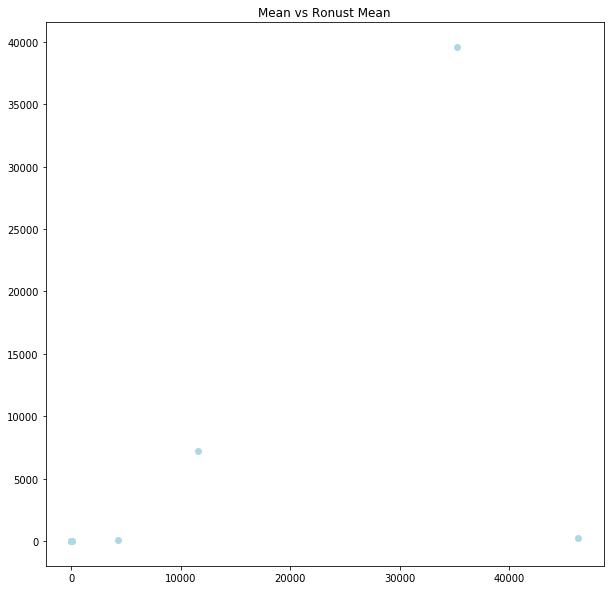

In [12]:
print(norm_train_df.mean())
print(ell_model.location_)
fig, ax = ply.subplots(figsize=(10, 10))
ax.scatter(norm_train_df.mean(),ell_model.location_,marker="o", color="lightBlue")
ax.set_title('Mean vs Ronust Mean')

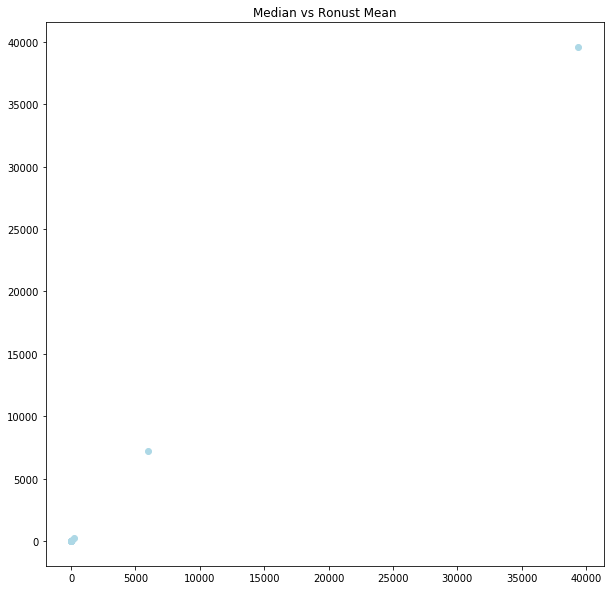

In [13]:
fig, ax = ply.subplots(figsize=(10, 10))
ax.scatter(norm_train_df.median(),ell_model.location_,marker="o", color="lightBlue")
ax.set_title('Median vs Ronust Mean')

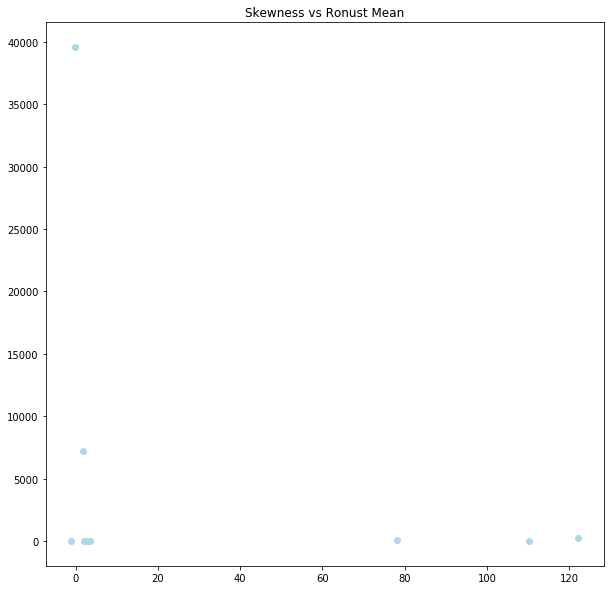

In [14]:
fig, ax = ply.subplots(figsize=(10, 10))
ax.scatter(norm_train_df.skew(),ell_model.location_,marker="o", color="lightBlue")
ax.set_title('Skewness vs Ronust Mean')

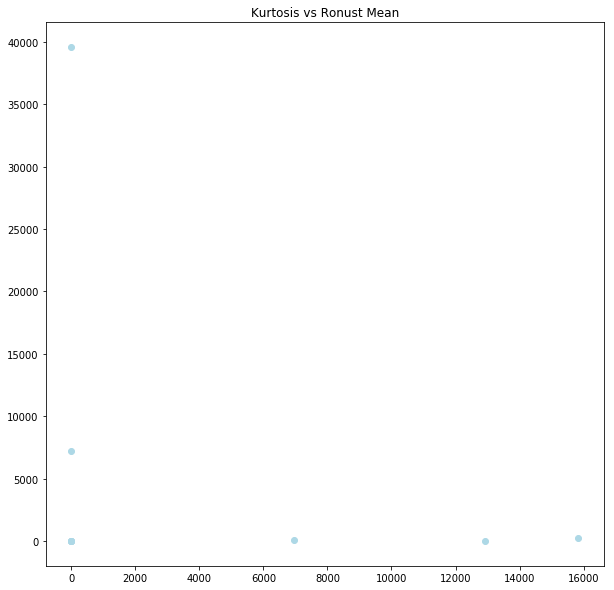

In [15]:
fig, ax = ply.subplots(figsize=(10, 10))
ax.scatter(norm_train_df.kurt(),ell_model.location_,marker="o", color="lightBlue")
ax.set_title('Kurtosis vs Ronust Mean')